# Bayesian Networks and Gibbs Sampling

> Bayesian Networks are models that try to explain dependent relationships in the real world. Data scientists can use Bayesian Networks as a way to graphically explain a wide range of causal phenomenom. See diagram 1 below for a simple example of bayesian networks in practice. 
>Furthermore, Bayesian networks can be used for inference; as you will see in the tutorial, models can can learn from the data they receive and accept or reject statistician's hypotheses. 

## Introducing Bayesian Networks

>[Bayesian Networks](https://www.bayesserver.com/docs/introduction/bayesian-networks) are directed graphs that can model variables as nodes with the power to graphically and mathmatically convey many types of relationships in a causal system -- Bayes Theorem is the power behind the computation of the probability of each node in the network. As we saw in class, we can use [Bayes Theorem](https://medium.com/@akankshamalhotra24/naive-bayes-theorem-79832d506a63) to compute the likelihood of an event by considering the prior and likelihood.

![alt text](img/bayestheorem.png "Title")

## Diagram 1: Bayesian Network for reasoning about the grass being wet

![alt text](img/bayesnet.png "Title")

**The ability to compute conditional probability is the engine behind computing the probabilities of nodes in a bayesian network -- knowledge of the other nodes helps drive the inference making abilities of the network.** 


All of the conditional probabilties between nodes should be explicit in a Bayesian network model in what we refer to as a **Conditional Probabilty Table** (CPT). 
    
As you can see, this diagram displays the corresponding conditional probabilties at each node. 

>Any four nodes can be activated or off at one time -- there are 2^4 = 16 possible combinations of nodes in this graph. Each permutation has a joint probability, which can be computed by multiplying the corresponding cells of all four nodes in the given permutation. All of the joint probabilities of the 16 possible combinations will add up to one. 

The possible probabilities for each node are by definition dependent on their values of their input nodes.

>For example the probability that all four nodes are "true" can be computed by: (.99) x (.8) x (.5) x (.1) = (0.0396)

## Rice Pudding Inference in the Gibbs Family

*The Gibbs, a four person family from Metropolopia, has certain traditions that may seem odd to outsiders. They absolutely **love** making and eating rice pudding. Although, they share a common love for the dessert, they share it only according to very strigent rules and customs which contribute to a philosophy of respecting elders.*

## Family Sharing Rules for Rice Pudding

 

* They each cook ricepudding around once a week (15% of all days)

* They always cook leftover with enough to serve the whole family -- but by tradition, they only offer rice pudding to the family member born directly before them. Hence the eldest never shares.

* Once in a while  a family member does not feel like sharing their pudding with family. 

## Converting the rules to a Bayesian Network

**Based off of the rules, we can model the probabilty that a specific person in the family will receive pudding on an arbitrary day with a bayesian network. Below are the name of the 4 members of the family.**

* Little Mia          (youngest)             = $M_{4}$
 
* Maria-Jose     (second youngest)      = $M_{3}$

* Mother Marge   (second oldest)        = $M_{2}$

* Dad Matthew    (oldest)               = $M_{1}$

If a node M~i = 1, this will indicate that this person will have access to rice pudding--either from cooking it for themself or getting it from someone else or both!

Because both of these causal factors could happen in at the same time, in order to compute the conditional probability of $M_{1}$, $M_{2}$, $M_{3}$, we need to apply the inclusion-exclusion principle of sets to find P( $M_{i}$ = 1 given $M_{i}$+1=1) and P($M_{i}$=0 given $M_{i}$+1=1)


In layman terms: 
P($M_{i}$=1 given $M_{i}$+1=1) = P(make their own rice pudding) + P(the person before them gives them ricepudding that they made) - (probability of both of things happening at the same time)


```
.15 + .8 + (.15*.8)

= .95 - (.12) = .83
```

As a result, we can now construct our bayesian network for the family.


![alt text](img/puddingThough.png "Title")

## Implementing the graphical model in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

>Before we try to estimate the posterior distribution, we are going to encode the CPT's as arrays in python and then store the different CPT's in a python array. The finite amount of cases can all be covered from these conditional probabilities.  

**$M_{4}$ has a different structure from the rest of the nodes, for the sake of simplicity**

In [3]:
#CPT have to be explicitly declared in python array
#cited below

cpt_m4 = [0.85, 0.15]
cpt_m3 = [[0.85, 0.15], [0.17, 0.83]]
cpt_m2 = [[0.85, 0.15], [0.17, 0.83]]
cpt_m1 = [[0.85, 0.15], [0.17, 0.83]]

cpts = [cpt_m4, cpt_m3]


## Markov chain Monte Carlo (MCMC)

Markov chain Monte Carlo refers to a class of algorithms which attempt to define a probability distribution with a correlated sequence of samples.  If we have access to the joint density of a function, and want to get the mean or variance of the marginal probabilty density function of a random variable x, we might have too many variables in order to easily calculate the integrations necessary to getting those values.

> Below the stationary distribution (pictured in orange) approximates the actual probability distribution (pictured in blue)

**If we want to know the true causal likelihood of different states in a bayesian network, rather than integrating, we can randomly sample from the posterior distribution in order to estimate it.**

### Cited below

![alt text](img/MCMCting.png "Title")

## Gibbs Sampling

We are going to write an implementaion of the gibbs sampling algorithm to demonstrate how a random walk can converge to samples that will estimate the posterior.  

# Implementing the Algorithm

First we randomly pick a permutation of numbers. Suppose S is some assignment of variables of all of the variables except $v_{i}$. 

>The most important part of the algorithm to understand that if all other variables are left the same then the ratio between the two functions


> 1 . (joint probability of $v_{i}$ = 0 given S) / (joint probability of $v_{i}$ = 1 given S) 


is equivalent to the ratio between 


> 2 . (P(v2 = 0 | S) / (P(v2 = 1 | S))

This helper function allows me to replace all of the extra None values in the input array to 0. This is useful, because my temp array has to assign all values except $v_{i}$. 

In [4]:
def zeroReplace(tempList):
    newList = tempList.copy()
    for i in range(len(tempList)):
        if (tempList[i] == None):
            newList[i] = 0
    return newList

**Gibbs:** 
>The gibbs sampling estimate takes in sample size and the conditional probabilities of all the variables to estimate the marginal density function for a bunch of variables. Which will be accumulated in a matrix of samples with every column belonging to a family member while the rows will accumilate whether or not the family member had access to pudding in that sample

sample_size : integer which enotes the amount of samples we want to take
cpts : array of tuple arrays - the conditional probability tables describing our bayesian network
For ex... cpts[0] = the cpt for M4, Moana 

cpts[i][0][0] = the prior probability of M[4-i] not getting rice pudding
cpts[i][0][1] = the prior probability of M[4-i] getting rice pudding

Value Test is an array representing Bayes Network with specific nodes valued as non-types, which. 

jointProbabability : multiplies all of the relevant cpt cell probabilities  specified by temp_list.


cpts: data structure defined above
temp_list : a proposal of states for variables in the bayesian network to take on

In [5]:
#cited below
def jointProbability(temp_list, cpts):
    famsize = len(temp_list)
    # data structure is different for the first element of cpts
    prob = cpts[0][temp_list[0]]
    for i in range(1,famsize):
        tempVal = cpts[1][temp_list[i-1]][temp_list[i]] 
        prob = prob * tempVal
    return prob

In [6]:
def gibbs(fam, cpts, sample_size):
    
    total_nodes = len(fam)
    
    all_samples = np.zeros((sample_size, total_nodes))    
    
    # make a temp list copy of 
    tempyCopy = fam.copy()
    
    #make a temp value with all the Nones set to zero
    tempCopy = zeroReplace(fam)
        
    for i in range(sample_size):
        #first pass, go through the variables in a random order
        #try it without random order too!
        random_order = np.random.permutation(total_nodes)
        
        for j in random_order:
            
            if (fam[j] == None):
                
                tempList = tempCopy
               
                #tempList[j] set to zero
                jointProbNumer = jointProbability(tempList, cpts)
                
                #Now we are going to try to compute the joint probability with variable j set to 1
                newList2 = tempCopy
                newList2[j] = 1
                jointProbDenom = jointProbability(newList2, cpts)
                sumProb = jointProbNumer + jointProbDenom 
                ratioNumer = jointProbNumer / sumProb
                ratioDenom = 1 - ratioNumer
                probBounds = [ratioNumer, ratioDenom]
                
                # creates the markov chain by sampling a new sample based off the probability ratio 
                # between P(v=0 | some sequence) / P(v=1 | some sequence)
                tempCopy[j] = np.argmax(np.random.multinomial(1, pvals=probBounds))
                
        all_samples[i] = tempCopy
        
    return all_samples

In [7]:
import matplotlib.patches as patches
import matplotlib.path as path


def plotGibbsResults(varAssignment, cpts, sample_size):
    stringOfSample = str(sample_size)
    all_samples = gibbs(varAssignment, cpts, sample_size)
    meanOfSample = np.mean(all_samples, axis=0)
    famSize = len(meanOfSample)
    x = range(1,5)
    ind = range(1, 5)
    plt.bar(x, meanOfSample, color='c', align="center")
    plt.xticks(ind, x) 
    plt.xlabel = ('Fam')
    plt.ylabel = ('% Rice Pudding Access')
    plt.title('Rice Pudding Access\n over %s sampled days in Gibbs Family'%stringOfSample)
    axis1 = plt.gca()
    axis1.set_ylim([0,1])
    axis1.set_ylabel('Percent of days with pudding access')
    axis1.set_xticklabels(['Moana', 'Maria-Jose', 'Marge', 'Dad Matthew'])
    
    


Below we will see what will happen if we run gibbs on a our bayesian network defined with the CPTs we developed earlier. 

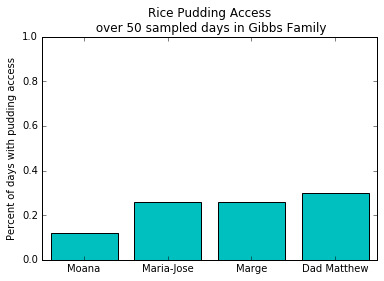

In [8]:
noFixedValues = np.array([None, None, None, None])
plotGibbsResults(noFixedValues, cpts, 50)

Something went wrong. In order to get a more accurate estimate of the distribution of random variables, the gibbs sampling.

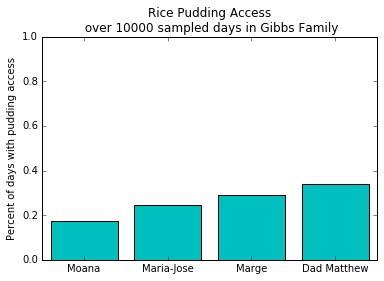

In [9]:
plotGibbsResults(noFixedValues, cpts, 10000)

This looks better. We can also fix values and how the family distribution of rice pudding would look in hypothetical universe. Below we show a universe where Baby Moana somehow has acess to an unlimited supply of rice pudding for the rest of her life.  The graph displays how frequently certain family members would have access to rice pudding in this alternate simulation.

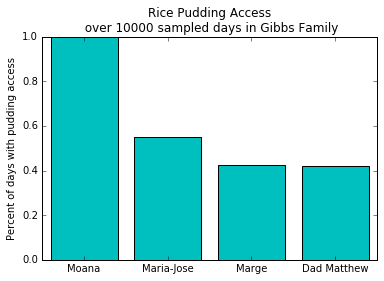

In [10]:
moanaRich = np.array([1, None, None, None])
plotGibbsResults(moanaRich, cpts, 10000)

One last idea which we should account for is burn-in. Essentially the point of accounting for burn-in is so a certain set of your samples in the beginning aren't included, because their present in the sample set could have easily biased by the luck of the draw in the initial sample.

In [11]:
def bestGibbsPlot(varAssignment, sample_size, cpts, burn_in):
    stringOfSample = str(sample_size)
    all_samples = gibbs(varAssignment, cpts, sample_size)
    all_samples = all_samples[burn_in:]
    meanOfSample = np.mean(all_samples, axis=0)
    famSize = len(meanOfSample)
    x = range(1,5)
    ind = range(1, 5)
    plt.bar(x, meanOfSample, color='c', align="center")
    plt.xticks(ind, x)
    plt.xlabel = ('Fam')
    plt.ylabel = ('% Rice Pudding Access')
    plt.title('Rice Pudding Access\n over %s sampled days in Gibbs Family'%stringOfSample)
    axis1 = plt.gca()
    axis1.set_ylim([0,1])
    axis1.set_ylabel('Percent of days with pudding access')
    axis1.set_xticklabels(['Moana', 'Maria-Jose', 'Marge', 'Dad Matthew'])
    


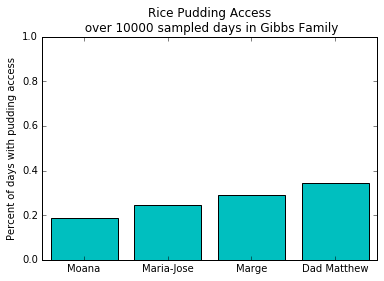

In [12]:
moanaRich = np.array([None, None, None, None])
bestGibbsPlot(moanaRich, 10000, cpts, 1000)

### Summary and references 


**This tutorial highlighted applications of bayesian networks and how to apply Markov Chain Monte Carlo methods to correlated events in the real world. **

>The cool thing about Monte Carlo methods is that they intuitively make sense in terms of how people reason about the world. The prior probalities represent of expecations based off our data in the past, like how frequently our friend Maria-Jose cooks up rice pudding.

>Gibbs sampling demonstrates how variables outlined in Bayesian networks can be used as a platform for probablistic inference in a wide variety of scenarios. 

To read a more intuitive explanation of MCMC I recommend the following site for those interested... https://jeremykun.com/2015/04/06/markov-chain-monte-carlo-without-all-the-bullshit/

1. Bayesian Networks: https://www.bayesserver.com/docs/introduction/bayesian-networks
 
2. Bayes Theorem: https://medium.com/@akankshamalhotra24/naive-bayes-theorem-79832d506a63

3. Gibbs Sampling: http://www.mit.edu/~ilkery/papers/GibbsSampling.pdf

4. MCMC picture: 2https://upload.wikimedia.org/wikipedia/commons/5/5e/Metropolis_algorithm_convergence_example.png

5. More Gibbs Sampling https://www.youtube.com/watch?v=a_08GKWHFWo&t=90s

6. Joint probability implementation reference: PS5 - Learning in Humans and Machines Spring 2018
